# 1. Introduction Bayesian Online Changepoint Detection

Implementing the online algorithm for online point detection using a bayesian approach.

## 1.1 Imports

In [16]:
from __future__ import division
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score

import tensorflow_probability as tfp
from matplotlib.pyplot import figure
from scipy.special import gammaln
import matplotlib.pyplot as plt
from functools import partial
import statsmodels.api as sm
import matplotlib.cm as cm
from scipy import stats
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
from math import *
import os

sns.set_style('white')

## 2. Algorithm

The paper [Bayesian Online Changepoint Detection](https://arxiv.org/pdf/0710.3742.pdf) describes an algorithm for locating points in a timeseries for which the timeseries distribution significantly changes it's parameters. The algorithm reads one point at a time and provides an likelihood estiomation for it beeing a changepoint based on previous points. 
We represent points $x_{1}, x_{2}, ..x_{n}$ as a run if they are from the same distribution.
When we read a new point, either that point is from the same distribution, in which case the run length increases by one and updates the parameters of the distribution using Bayes theorem. If it is a changepoint, the run length is reset to zero and the parameters of the distribution are reset to default and updated based on the current point.

![Algorithm](obcd.png)

$P(r_{t+1}=0|r_{t}=n)=1/λ$ (1)

$P(r_{t+1}=n+1|r_{t}=n)=(1−1/λ)$ (2)

$P(r_{t+1}=m|r_{t}=n) = 0 $ (3)

Process starts at $t=0$ with length = 0 and hyperparameters $\chi_{1} (0) = 0$

Supose we run algorithm for t-1 steps:

We have $r_{t-1}(n) $  the probability of run length $n = 0,1,...t-1$ at $time = t - 1$.

$P(r_{t-1},x_{1},x_{2},...x_{t-1})$ = total probability distribution

From (1) (2) (3) $P(r_{t}|r_{t-1}) = 1-1/λ $ when not changepoint otherwise $P(r_{t}|r_{t-1}) = λ$ 

**Step 4** Probability to continue run:
$P(r_{t},x_{1},x_{2},...x_{t}) = \sum_{r_{t-1}} P(r_{t}|r_{t-1})P(x_{t}|r_{t-1},x_{t}^r)P(r_{t-1},x_{1},...x_{t-1}) = \sum_{r_{t-1}} (1-1/λ)P(x_{t}|r_{t-1},x_{t}^r)P(r_{t-1},x_{1},...x_{t-1})$

**Step 5** Probability to be changepoint:
$P(r_{t}=0,x_{1},x_{2},...x_{t}) = \sum_{j=r_{t-1}} 1/λP(x_{t}|r_{t-1}=j,x_{1:t-1})P(r_{t-1}=j,x_{1},...x_{t-1})$

**Step 6,7** Distribution $r_{t}(n) = P(r_{t}=n,x_{1},x_{2},...x_{t})/P(x_{1},x_{2},...x_{t}) = P(r_{t}=n,x_{1},x_{2},...x_{t})/\sum_{j}P(r_{t}=j,x_{1},x_{2},...x_{t})$

**Step 8** Update hyperparameters using the observed point

If we assume the predictive distribution(a.k.a. likelihood) to be a normal distribution, then the posterior predictive distribution will be a Student T distribution and the prior will be a normal inverse gamma. If we assume that the predictive distribution to be a Poisson distribution, then the posterior will be a negative Binomial distribution and the prior a gamma distribution. We can use the [conjugate prior table](https://en.wikipedia.org/wiki/Conjugate_prior) to define hyperparameters for priors distributions and parameters update rules.

![Normal_inverse_distribution](wikipedia_normal_inverse.png)

In [21]:
def online_changepoint_detection(data, hazard_func, observation_likelihood):
    maxes = np.zeros(len(data) + 1)
    
    R = np.zeros((len(data) + 1, len(data) + 1))
    R[0, 0] = 1
    
    for t, x in enumerate(data):
        # Evaluate the predictive distribution for the new datum under each of
        # the parameters.  This is the standard thing from Bayesian inference.
        predprobs = observation_likelihood.pdf(x)
        #print(predprobs)
        # Evaluate the hazard function for this interval
        """Hazard function is 1/lambda"""
        H = hazard_func(np.array(range(t+1)))

        # Evaluate the growth probabilities - shift the probabilities down and to
        # the right, scaled by the hazard function and the predictive
        # probabilities.
        """P(r_t, x1, x2 ... x_t = (1-1/lambda)* - hazard function
                                   P(x_t | r_(t-1)=(n-1), x1, x2...x_(t-1))* - computed fron prediction probability
                                   P(r_(t-1)=(n-1),x1, x2 ...x_(t-1)) - known from recursion
        """
        R[1:t+2, t+1] = R[0:t+1, t] * predprobs * (1-H)
        
        # Evaluate the probability that there *was* a changepoint and we're
        # accumulating the mass back down at r = 0.
        """P(r_t=0, x1, x2... xn) = SUM(lambda* - hazard function
                                        P(x_t|r_(t-1)=j,x,x2...x(t-1)* - computed fron prediction probability
                                        P(r_(t-1)=j,x1,x2...x(t-1))) - known from recursion
        """
        R[0, t+1] = np.sum( R[0:t+1, t] * predprobs * H)
        
        # Renormalize the run length probabilities for improved numerical
        # stability.
        """r_t(n) = P(t_t=n, x1, x2...xt)/SUM(r_t=j,x1, x2 ... xt)"""
        R[:, t+1] = R[:, t+1] / np.sum(R[:, t+1])
        
        # Update the parameter sets for each possible run length.
        observation_likelihood.update_theta(x)
    
        maxes[t] = R[:, t].argmax()
    return R, maxes

def constant_hazard(lam, r):
    return 1/lam * np.ones(r.shape)


class StudentT:
    """For Normal distribution likelyhood:
       StudentT as posterior predictive distribution
       Prior hyperparameters: alpha, beta, kappa=miu, mu
    """
    def __init__(self, alpha, beta, kappa, mu):
        self.alpha0 = self.alpha = np.array([float(alpha)])
        self.beta0 = self.beta = np.array([float(beta)])
        self.kappa0 = self.kappa = np.array([float(kappa)])
        self.mu0 = self.mu = np.array([float(mu)])

    def pdf(self, data):
        """Posterior predictive: student_t(x' | mean', beta'*(miu'+1)/(miu'*alpha')"""
        return stats.t.pdf(x=data, 
                           df=2*self.alpha,
                           loc=self.mu,
                           scale=np.sqrt(self.beta * (self.kappa+1) / (self.alpha*self.kappa)))

    def update_theta(self, data):
        """Posterior hyperparameters: mean' = (mean0*miu+n*mean)/(miu+n)
                                      miu' = miu + n
                                      alpha' = alpha + n/2
                                      beta' = beta + 1/2*(SUM(x_i-x_heat)^2 + (n*miu)*(x_hat-miu_0)^2/(2*(miu+n)))
        """
        muT0 = np.concatenate((self.mu0, (self.kappa * self.mu + data) / (self.kappa + 1)))
        kappaT0 = np.concatenate((self.kappa0, self.kappa + 1.))
        alphaT0 = np.concatenate((self.alpha0, self.alpha + 0.5))
        betaT0 = np.concatenate((self.beta0, self.beta + (self.kappa * (data - self.mu)**2) / (2. * (self.kappa + 1.))))
            
        self.mu = muT0
        self.kappa = kappaT0
        self.alpha = alphaT0
        self.beta = betaT0

class Poisson:
    """For Poisson distribution likelyhood:
       Negative Binomial as posterior predictive distribution
       Prior hyperparameters: k, theta
    """
    def __init__(self, k, theta):
        self.k0 = self.k = np.array([k])
        self.theta0 = self.theta = np.array([theta])

    def pdf(self, data):
        """Posterior predictive: NB(x' | k', theta')"""
        return stats.nbinom.pmf(data,self.k, 1/(1+self.theta))

    def update_theta(self, data):
        """Posterior hyperparameters: k' = SUM{x_i} + k and theta' = theta/(n*theta+1)"""
        kT0 = np.concatenate((self.k0, self.k+data))
        thetaT0 = np.concatenate((self.theta0, self.theta/(1+self.theta)))

        self.k = kT0
        self.theta = thetaT0


In [25]:
#multivariate

def online_changepoint_detection(data, hazard_func, observation_likelihood):
    maxes = np.zeros(len(data) + 1)
    flag = False
    cnt = 0
    change = False
    
    CP = np.zeros(1)
    last_cp = 0
    prev_cp = 0
    
    R = np.zeros((len(data) + 1, len(data) + 1))
    R[0, 0] = 1
    
    for t, x in enumerate(data):
        curr_t = int(t - last_cp)
        
        # Evaluate the predictive distribution for the new datum under each of
        # the parameters.  This is the standard thing from Bayesian inference.
        predprobs = observation_likelihood.pdf(x)
        
        #print(predprobs)
        # Evaluate the hazard function for this interval
        """Hazard function is 1/lambda"""
        H = hazard_func(np.array(range(curr_t+1)))

        # Evaluate the growth probabilities - shift the probabilities down and to
        # the right, scaled by the hazard function and the predictive
        # probabilities.
        """P(r_t, x1, x2 ... x_t = (1-1/lambda)* - hazard function
                                   P(x_t | r_(t-1)=(n-1), x1, x2...x_(t-1))* - computed fron prediction probability
                                   P(r_(t-1)=(n-1),x1, x2 ...x_(t-1)) - known from recursion
        """
        R[1:curr_t+2, t+1] = R[0:curr_t+1, t] * predprobs * (1-H)
        
        # Evaluate the probability that there *was* a changepoint and we're
        # accumulating the mass back down at r = 0.
        """P(r_t=0, x1, x2... xn) = SUM(lambda* - hazard function
                                        P(x_t|r_(t-1)=j,x,x2...x(t-1)* - computed fron prediction probability
                                        P(r_(t-1)=j,x1,x2...x(t-1))) - known from recursion
        """
        R[0, t+1] = np.sum( R[0:curr_t+1, t] * predprobs * H)
        
        # Renormalize the run length probabilities for improved numerical
        # stability.
        """r_t(n) = P(t_t=n, x1, x2...xt)/SUM(r_t=j,x1, x2 ... xt)"""
        R[:, t+1] = R[:, t+1] / np.sum(R[:, t+1])
        
        
        maxes[t] = R[:, t].argmax()
        
        RAND_VAL = -20
        RAND_VAL2 = 10
        
        if t > 0 and (maxes[t]- maxes[t-1]) < RAND_VAL:
            flag = True
            observation_likelihood.curr_theta()
        elif flag == True and t > 0:
            if abs(maxes[t]- maxes[t-1]) < RAND_VAL2:
                cnt += 1
                if cnt > RAND_VAL2:
                    change = True
                    flag = False
                    cnt = 0
                    CP = np.concatenate((CP, t-maxes[t]+1))
                    prev_cp = last_cp
                    last_cp  =CP[-1]
                    curr_t = int(t-last_cp)
                    observation_likelihood.save_theta()
                else:
                    flag = False
                    cnt = 0
        if change == True:
            observation_likelihood.reset_theta(curr_t)
            change = False
                
        # Update the parameter sets for each possible run length.
        observation_likelihood.update_theta(x)
    observation_likelihood.curr_theta()
    observation_likelihood.save_theta()
    theta = observation_likelihood.retrieve_theta()
    
    return R, maxes, CP, theta

class MultivariateStudentT:
    """For multivariate Normal distribution likelyhood:
       multivariate StudentT as posterior predictive distribution
       Prior hyperparameters: psi, kappa, miu, mu
    """
    def __init__(self, dim):
        self.nu0 = self.nu = np.array(dim)
        self.Lambda0 = self.Lambda = Lambda=np.eye(dim)
        self.kappa0 = self.kappa = np.array(1)
        self.mu0 = self.mu = np.zeros(dim)
        self.dim = dim
        self.curr_mean = self.mu0
        self.curr_cov = self.Lambda0
        self.saved_mean = []
        self.saved_cov = []
        
    def pdf(self, data):
        df=self.nu
        dim=self.dim
        loc=self.mu
        lam=self.Lambda
        length=int(np.size(loc) / dim)
        mult = np.zeros(length)
        scale = np.zeros((length,dim,dim))
        if length == 1 :
            scale=np.linalg.inv(lam * (2*(self.kappa+1)) / (df * self.kappa))
            mult=[np.matmul(np.matmul((data-loc),scale),np.transpose(data-loc))]
        else :
            scaling = np.transpose([2*(self.kappa+1) / (df * self.kappa)])
            for i in range(length):
                scale[i]=np.linalg.inv(lam[i] * scaling[i])
                mult[i]=np.dot(np.dot((data-loc)[i],scale[i]),np.transpose((data-loc)[i]))
        (sign, logdet) = np.linalg.slogdet(scale)
        logc = gammaln(df/2.0 + dim/2.0) - gammaln(df/2.0) + 0.5*logdet - (dim/2.0)*np.log(df*np.pi)
        logc = np.transpose(logc)
        """Posterior predictive: student_t(x' | mean', (kappa0'+1)/(kappa0'*(miu0'-p+1))*psi') where psi=sigma*miu"""
        return np.exp(logc - (df/2.0 + dim/2.0)*np.log1p(mult/df))

    def update_theta(self, data):
        """Posterior hyperparameters: k' = SUM{x_i} + k and theta' = theta/(n*theta+1)
        """
        if np.size([self.mu], axis=-2) > 1 :
            kappa = np.transpose([self.kappa])
            muT0 = np.concatenate(([self.mu0], (kappa * self.mu + data) / (kappa + 1)))
            kappaT0 = np.concatenate(([self.kappa0], self.kappa + 1))
            nuT0 = np.concatenate(([self.nu0], self.nu + 1))
            x_mu = data - self.mu
            length=np.size(kappa)
            Lambda = np.zeros((length,self.dim,self.dim))
            for i in range(length) :
                Lambda[i] = self.Lambda[i] + (kappa[i] * np.matmul(np.transpose([x_mu[i]]), ([x_mu[i]])) / (2. * (kappa[i] + 1.)))
                LambdaT0 = np.concatenate(([self.Lambda0], Lambda))
        else :
            muT0 = np.stack((self.mu0, (self.kappa * self.mu + data) / (self.kappa + 1)))
            kappaT0 = np.stack((self.kappa0, self.kappa + 1))
            nuT0 = np.stack((self.nu0, self.nu + 1))
            x_mu = data - self.mu
            LambdaT0 = np.stack((self.Lambda0, self.Lambda + (self.kappa * np.matmul(x_mu.transpose(), x_mu) / (2. * (self.kappa + 1.)))))
            
        self.mu = muT0
        self.kappa = kappaT0
        self.nu = nuT0
        self.Lambda = LambdaT0
        

    def curr_theta(self):
        self.curr_mean = self.mu[-2]
        self.curr_cov = self.Lambda[-2] * 2*(self.kappa[-2]+1) / (self.nu[-2] * self.kappa[-2])

    def save_theta(self):
        if np.size(self.saved_mean):
            self.saved_mean = np.concatenate((self.saved_mean, [self.curr_mean]))
        else:
            self.saved_mean = [self.curr_mean]
        if np.size(self.saved_cov):
            self.saved_cov = np.concatenate((self.saved_cov, [self.curr_cov]))
        else:
            self.saved_cov = [self.curr_cov]
            
    def reset_theta(self, t):
        self.mu = self.mu[0:t+1]
        self.kappa = self.kappa[0:t+1]
        self.nu = self.nu[0:t+1]
        self.Lambda = self.Lambda[0:t+1]

    def retrieve_theta(self):
        return self.saved_mean, self.saved_cov

## 3. Testing Student-T on real data from dataset

Test on yahoo dataset with precission, recall, and f1 score. We have to chose wiselly the number of samples(Nw) anomaly threshold(thr).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


Precision:  real_66.csv 0.492600422832981
Recall:  real_66.csv 0.4982181040627227
Precision:  real_1.csv 0.4992952783650458
Recall:  real_1.csv 0.49964739069111425
Precision: 0.50 (+/- 0.01)
Recall: 0.50 (+/- 0.00)
F1-Score: 0.50


<Figure size 2000x18400 with 0 Axes>

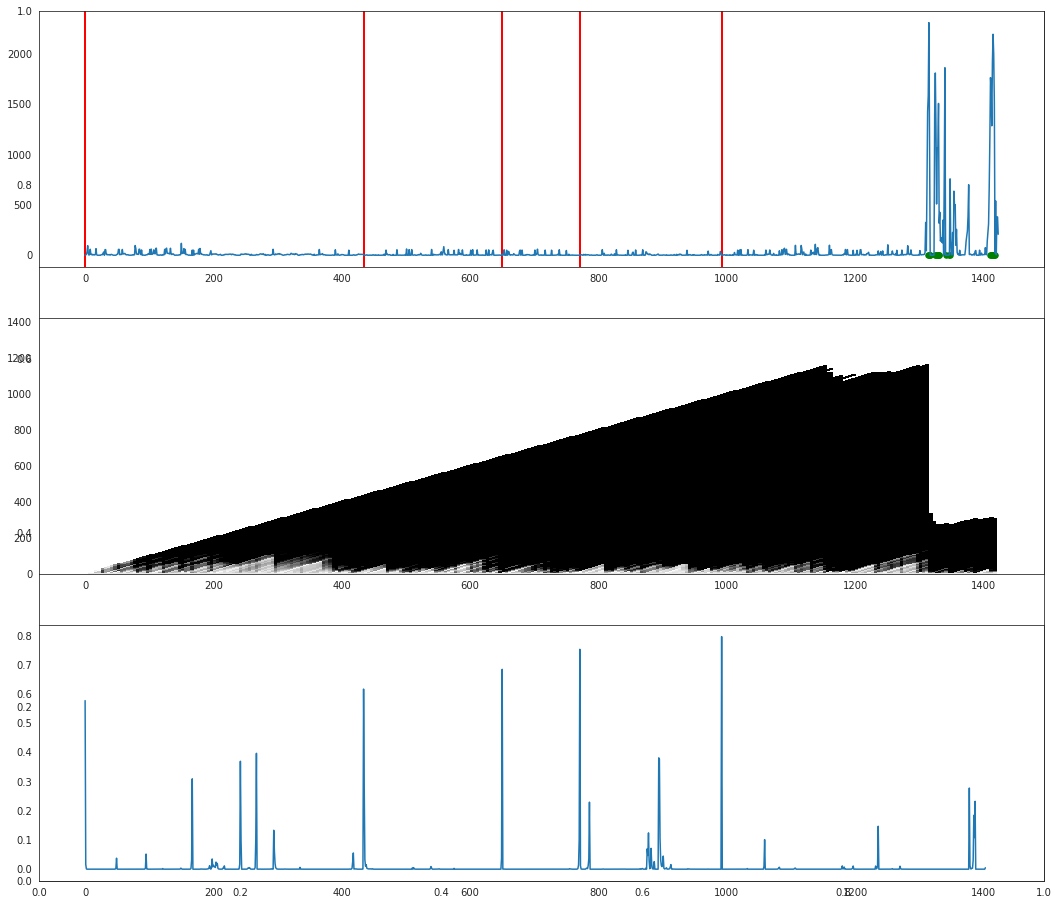

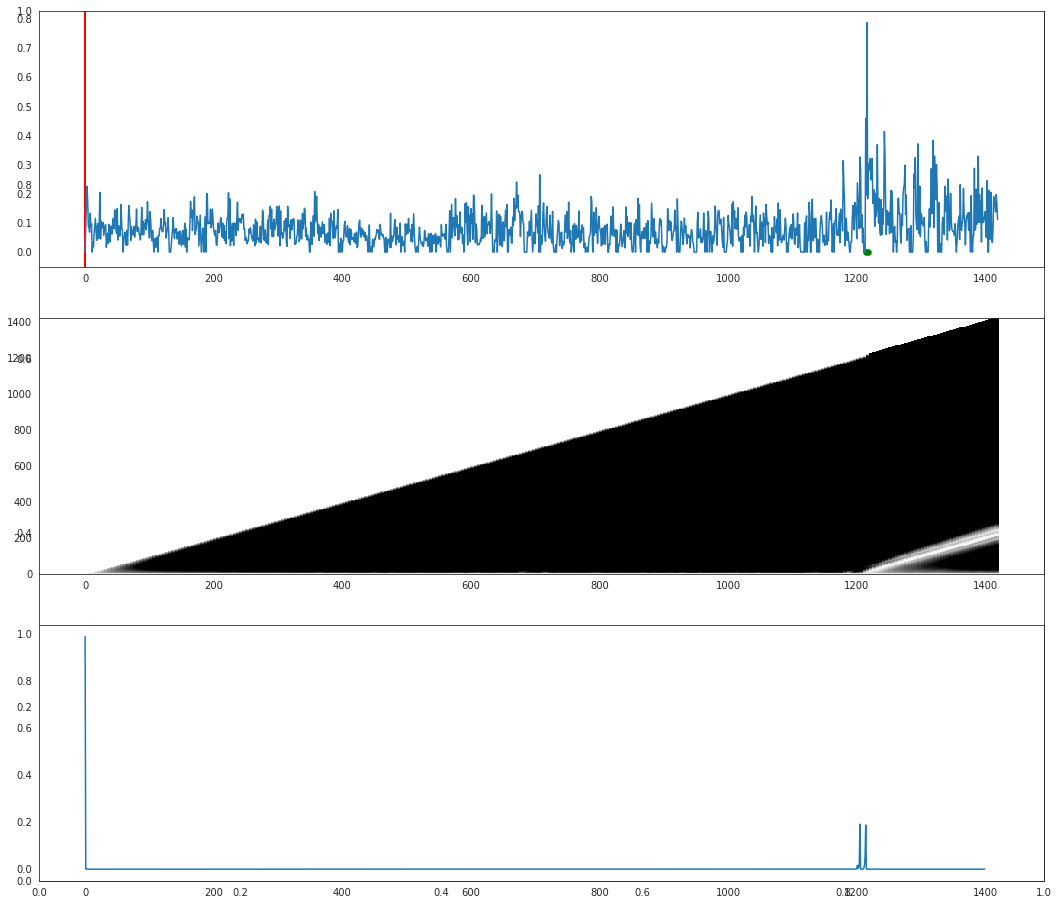

In [23]:
figure(num=None, figsize=(25, 230), dpi=80, facecolor='w', edgecolor='k')

prec = []
rec = []

columns = ["value"]
folder = "./ydata-2/A1Benchmark/"
filenames = os.listdir(folder)
rows_fig = len(filenames)
Nw=20
thr = 0.5

#read real data
for i, filename in zip(range(rows_fig), filenames[:2]):

    alldata_yahoo = pd.read_csv(folder + filename)
    R, maxes = online_changepoint_detection(alldata_yahoo[columns[0]], partial(constant_hazard, 150), StudentT(alpha=1, beta=1, kappa=1, mu=0))

    fig, ax = plt.subplots(figsize=[18, 16])
    ax = fig.add_subplot(3, 1, 1)
    
    prec_pred = np.zeros(len(alldata_yahoo))
    rec_pred = np.zeros(len(alldata_yahoo))
    
    #plot predicted anomalies
    for o in np.argwhere(R[Nw,Nw:-1] > thr):
        prec_pred[o] = 1
        rec_pred[o] = 1
        plt.axvline(x=o, linewidth=2, c="r")
    
    #plot real anomalies
    plt.scatter(alldata_yahoo["timestamp"][alldata_yahoo["is_anomaly"] == 1],[0]*len(alldata_yahoo["timestamp"][alldata_yahoo["is_anomaly"] == 1]),s=30,c="g")

    ax.plot(alldata_yahoo[columns[0]])
    ax = fig.add_subplot(3, 1, 2, sharex=ax)
    sparsity = 5 # only plot every fifth data for faster display
    ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)),
              np.array(range(0, len(R[:,0]), sparsity)),
              -np.log(R[0:-1:sparsity, 0:-1:sparsity]),
              cmap=cm.Greys, vmin=0, vmax=30)
    ax = fig.add_subplot(3, 1, 3, sharex=ax)
    
    print("Precision: ", filename, precision_score(alldata_yahoo["is_anomaly"], prec_pred, average='macro'))
    print("Recall: ", filename, recall_score(alldata_yahoo["is_anomaly"], rec_pred, average='macro'))
    
    ax.plot(R[Nw,Nw:-1])
    #print(np.argwhere(R[Nw,Nw:-1] > 0.5))
    #plt.savefig("imagine_online.png")
    prec.append(precision_score(alldata_yahoo["is_anomaly"], prec_pred, average='macro'))
    rec.append(recall_score(alldata_yahoo["is_anomaly"], rec_pred, average='macro'))
    
#print( prec)
p = np.mean(prec)
print("Precision: %0.2f (+/- %0.2f)" % (np.mean(prec), np.std(prec) * 2))
#print(rec)
r = np.mean(rec)
print("Recall: %0.2f (+/- %0.2f)" % (np.mean(rec), np.std(rec) * 2))

print("F1-Score: %0.2f" % ((2*p*r)/(p+r)))

## 4. Testing Multivariate Student-T

Test on multivariate generated data

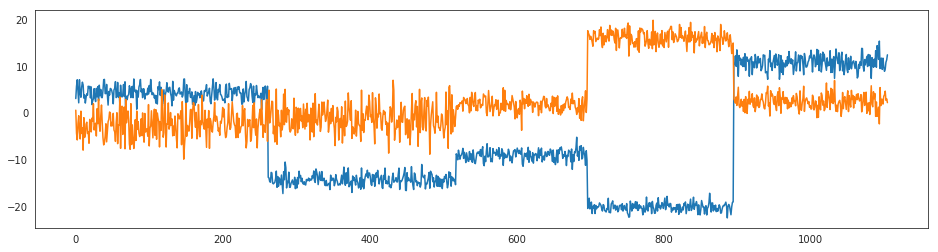

In [36]:
def generate_motivating_example(minl=50, maxl=1000):
    dim = 2
    num = 3
    partition = np.random.randint(minl, maxl, num)
    mu = np.zeros(dim)
    Sigma1 = np.asarray([[1.0,0.75],[0.75,1.0]])
    data = np.random.multivariate_normal(mu, Sigma1, partition[0])
    Sigma2 = np.asarray([[1.0,0.0],[0.0,1.0]])
    data = np.concatenate((data,np.random.multivariate_normal(mu, Sigma2, partition[1])))
    Sigma3 = np.asarray([[1.0,-0.75],[-0.75,1.0]])
    data = np.concatenate((data,np.random.multivariate_normal(mu, Sigma3, partition[2])))
    return partition, data

def generate_multinormal_time_series(num, dim, minl=50, maxl=1000):
    data = np.empty((1,dim), dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        mean = np.random.standard_normal(dim)*10
        # Generate a random SPD matrix
        A = np.random.standard_normal((dim,dim))
        var = np.dot(A,A.T)

        tdata = np.random.multivariate_normal(mean, var, p)
        data = np.concatenate((data, tdata))
    return partition, data[1:,:]

partition, data = generate_multinormal_time_series(5, 4, 100, 300)
changes = np.cumsum(partition)

fig, ax = plt.subplots(figsize=[16, 4])
#for p in changes:
#    ax.plot([p,p],[np.min(data),np.max(data)],'r')
for d in range(2):
    ax.plot(data[:,d])


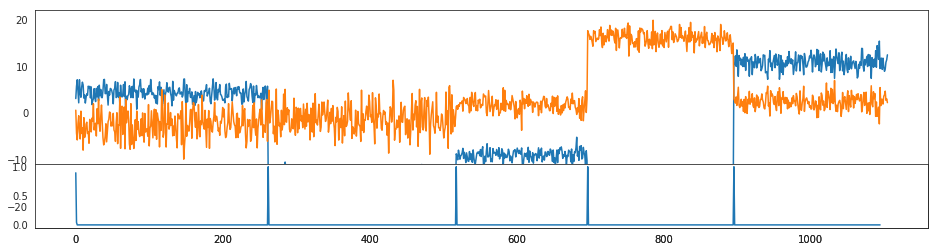

In [38]:
R, maxes, CP, theta = online_changepoint_detection(data, partial(constant_hazard, 150), MultivariateStudentT(4))
Nw = 10
fig, ax = plt.subplots(figsize=[16, 4])
for d in range(2):
    ax.plot(data[:,d])
#ax = fig.add_subplot(3, 1, 2, sharex=ax)
#sparsity = 5 # only plot every fifth data for faster display
#ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)),
#          np.array(range(0, len(R[:,0]), sparsity)),
#          -np.log(R[0:-1:sparsity, 0:-1:sparsity]),
#          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
    
ax.plot(R[Nw,Nw:-1])